In [1]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

In [1]:
img_rows = 224
img_cols = 224
color_type = 1
batch_size=20
epochs=300
cache = 'e:/kaggle_imgs/StateFarm'
img_path="E:/kaggle_imgs/Statefarm/Data/imgs"
subject="Digit_model"

import os
import shutil
if not os.path.exists(cache):
    #shutil.rmtree(cache)
    os.mkdir(cache)
saved_path="{}/saved_models".format(cache)
if not os.path.exists(saved_path):
    os.makedirs(saved_path)
file_path='{}/State_keras_200508_no_aug.hdf5'.format(saved_path)

train_pickle=cache+"/train_data2.pickle"
test_pickle=cache+"/test_data2.pickle"

In [2]:
# import module
from PIL import Image as IM
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from glob import glob
from time import time
from pickle import load, dump
from pandas import DataFrame, read_csv
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.metrics import log_loss
from keras.models import Sequential, Model
from keras.layers import Dropout,Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau

Using TensorFlow backend.


In [4]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

def get_image(path, img_rows, img_cols, color_type):
    img = IM.open(path)
    img = img.resize((img_rows,img_cols))
    img = np.array(img)
    img = rgb2gray(img)
    return img

def load_train(img_rows, img_cols, color_type, paths):
    images = []
    labels = []
    for i in range(10):
        start = time()
        files = glob(paths[i])
        for file in files:
            images.append(get_image(file, img_rows, img_cols, color_type))
            labels.append(i)
        print('directory {} loaded in {:.2f} seconds, count:{}'.format(paths[i], time() - start, len(files)))
    return images, labels

def normalized_train(img_rows, img_cols, color_type,image_path):
    path=[]
    for i in range(10):
        path.append('{}/train/c{}/*.jpg'.format(img_path,i))
    print(path)
    images, labels = load_train(img_rows, img_cols, color_type,path)
    labels = np_utils.to_categorical(labels, 10)
    return images,labels

def load_test(img_rows, img_cols, color_type, path):
    images = []
    files = glob(path)
    print("test images count :",len(files))
    for i,file in enumerate(files):
        images.append(get_image(file, img_rows, img_cols, color_type))
        if(i%1000==0):
            print("loading count is :",i)
    return images

def normalized_test(img_rows, img_cols, color_type,path):
    path='{}/test/*.jpg'.format(path)
    images = load_test(img_rows, img_cols, color_type, path)
    return images


In [5]:
# load train data
fp="{}/train_data.pickle".format(cache)
if os.path.exists(fp):
    try:
        print('loading train data from pickle', flush=True)
        with open(fp, 'rb') as f:
            train_images, valid_images, train_labels, valid_labels = load(f)
        print('complete!', flush=True)
    except EOFError:
        print('EOFError raised.', flush=True)
        print('loading train data...', flush=True)
        os.system('rm -f train_data.pickle')
else:
    print('loading train data...', flush=True)
    trains,labels=normalized_train(img_rows, img_cols, color_type,img_path)
    train_images, valid_images, train_labels, valid_labels = train_test_split(trains, labels, test_size=0.2)
    train_images = np.array(train_images, dtype=np.uint8).reshape(-1, img_rows, img_cols, color_type)
    valid_images = np.array(valid_images, dtype=np.uint8).reshape(-1, img_rows, img_cols, color_type)
    print('train load complete!', flush=True)
    print('pickling train data...', flush=True)
    with open(fp, 'wb') as f:
        dump((train_images, valid_images, train_labels, valid_labels), f)

loading train data from pickle
complete!


In [6]:
# load test data
fp="{}/test_data.pickle".format(cache)
if os.path.exists(fp):
    try:
        print('loading test data from pickle', flush=True)
        with open(fp, 'rb') as f:
            test = load(f)
        print('complete!', flush=True)
    except EOFError:
        print('EOFError raised.', flush=True)
        print('loading test data...', flush=True)
        os.system('rm -f test_data.pickle')
else:
    print('loading test data...', flush=True)
    test=normalized_test(img_rows, img_cols, color_type, img_path)
    test = np.array(test, dtype=np.uint8).reshape(-1, img_rows, img_cols, color_type)
    print('test load complete!', flush=True)
    print('pickling test data...', flush=True)
    with open(fp, 'wb') as f:
        dump(test, f)

loading test data from pickle
complete!


In [7]:
train_images.shape,test.shape

((17939, 224, 224, 1), (79726, 224, 224, 1))

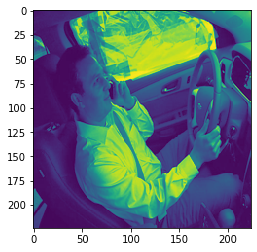

In [8]:
train_labels.sum(axis=0),valid_labels.sum(axis=0)
train_images=train_images/255.
valid_images=valid_images/255.
#test=test/255.
plt.imshow(train_images[100].reshape(224,224))

In [9]:
# stats
train_size = len(train_images)
valid_size = len(valid_images)
test_size = len(glob('data/imgs/test/*.jpg'))
print('stats:', flush=True)
print('{} train images'.format(train_size), flush=True)
print('{} validation images'.format(valid_size), flush=True)
print('{} test images'.format(test_size), flush=True)
print('train_images.shape = {}'.format(train_images.shape), flush=True)
print('train_labels.shape = {}'.format(train_labels.shape), flush=True)
print('valid_images.shape = {}'.format(valid_images.shape), flush=True)
print('valid_labels.shape = {}'.format(valid_labels.shape), flush=True)

stats:
17939 train images
4485 validation images
0 test images
train_images.shape = (17939, 224, 224, 1)
train_labels.shape = (17939, 10)
valid_images.shape = (4485, 224, 224, 1)
valid_labels.shape = (4485, 10)


In [10]:
checkpoint = ModelCheckpoint(filepath=file_path, 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=7)
learning_rate_reduction=ReduceLROnPlateau(monitor="val_acc",
                                          patience=3,
                                          verbose=1,
                                          factor=0.5,
                                          min_lr=0.00001)
callbacks = [checkpoint, es,learning_rate_reduction]

In [3]:
def get_model():
    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu', input_shape = (img_rows,img_cols,color_type)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.1))


    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.1))


    model.add(Flatten())
    model.add(Dense(64, activation = "relu"))
    model.add(Dropout(0.1))
    model.add(Dense(10, activation = "softmax"))
    return model


model = get_model()
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)       

In [12]:
# data augmentation configuration
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0, # Randomly zoom image 
        width_shift_range=0,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train_images)

In [13]:
training_generator = datagen.flow(train_images, train_labels, batch_size=batch_size)
#training_generator = (train_images,train_labels)
validation_data = (valid_images,valid_labels)

In [14]:
# image augmantion 실험
# if os.path.exists(file_path):
#     model.load_weights(file_path)
history = model.fit_generator(
    training_generator,
    epochs = epochs, 
    validation_data = validation_data,
    verbose = 1,
    steps_per_epoch = train_images.shape[0] // batch_size,
    callbacks=callbacks,
    validation_steps = valid_images.shape[0] // batch_size)

Epoch 1/300
896/896 [==============================] - 228s 255ms/step - loss: 0.5755 - accuracy: 0.8226 - val_loss: 0.0611 - val_accuracy: 0.9860

Epoch 00001: val_loss improved from inf to 0.06107, saving model to e:/kaggle_imgs/StateFarm/saved_models/State_keras_200508_no_aug.hdf5


C:\Users\ipofri-desktop\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


Epoch 2/300
896/896 [==============================] - 223s 249ms/step - loss: 0.0492 - accuracy: 0.9863 - val_loss: 0.0334 - val_accuracy: 0.9931

Epoch 00002: val_loss improved from 0.06107 to 0.03343, saving model to e:/kaggle_imgs/StateFarm/saved_models/State_keras_200508_no_aug.hdf5
Epoch 3/300
896/896 [==============================] - 223s 249ms/step - loss: 0.0249 - accuracy: 0.9925 - val_loss: 0.0484 - val_accuracy: 0.9922

Epoch 00003: val_loss did not improve from 0.03343
Epoch 4/300
896/896 [==============================] - 225s 251ms/step - loss: 0.0220 - accuracy: 0.9952 - val_loss: 0.0590 - val_accuracy: 0.9940

Epoch 00004: val_loss did not improve from 0.03343
Epoch 5/300
896/896 [==============================] - 223s 249ms/step - loss: 0.0274 - accuracy: 0.9932 - val_loss: 0.0549 - val_accuracy: 0.9942

Epoch 00005: val_loss did not improve from 0.03343
Epoch 6/300
467/896 [==============>...............] - ETA: 1:39 - loss: 0.0279 - accuracy: 0.9948

KeyboardInterrupt: 

NameError: name 'history' is not defined

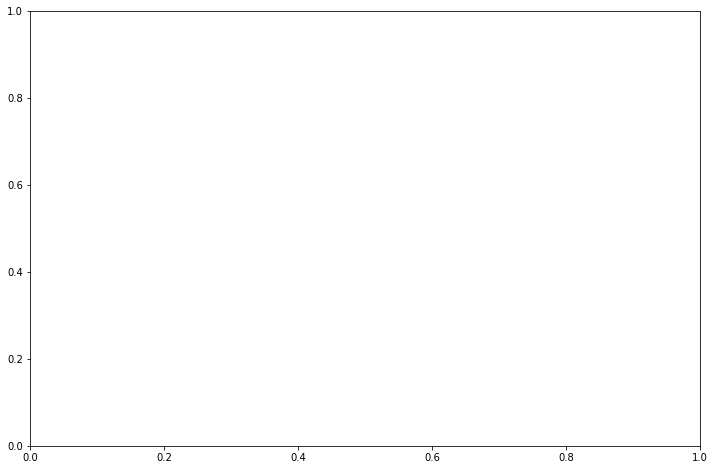

In [15]:
# plot history
plt.subplots(figsize=(12,8))
plt.plot(history.history['accuracy'],"r",label="train")
plt.plot(history.history['val_accuracy'],"bo",label="valid")
plt.title('Model accuracy')
plt.legend()
plt.show()

plt.subplots(figsize=(12,8))
plt.plot(history.history['loss'],label="Model")
plt.plot(history.history['val_loss'],"bo",label="loss")
plt.title('Model loss')
plt.legend()

#  Submission

In [4]:
if os.path.exists(file_path):
    model.load_weights(file_path)
    print("model load complete")
if os.path.exists(test_pickle):
    try:
        print('loading test data from pickle', flush=True)
        with open(test_pickle, 'rb') as f:
            (test_data,test_id) = load(f)
        print('complete!', flush=True)
    except EOFError:
        print('EOFError raised.', flush=True)
        print('loading test data...', flush=True)
test_data = test_data.astype('float32')
test_data =test_data/ 255

model load complete
loading test data from pickle
complete!


In [5]:
test_prediction = model.predict(test_data, batch_size=20, verbose=1)

79726/79726 [==============================] - 260s 3ms/step


In [6]:
yfull_test=[]
yfull_test.append(test_prediction)

In [7]:
import datetime
import pandas as pd
def merge_several_folds_mean(data, nfolds):
    a = np.array(data[0])
    for i in range(1, nfolds):
        a += np.array(data[i])
    a /= nfolds
    return a.tolist()

def create_submission(predictions, test_id, info):
    result1 = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result1.loc[:, 'img'] = pd.Series(test_id, index=result1.index)
    now = datetime.datetime.now()
    suffix = info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join(cache, 'submission_' + suffix + '.csv')
    result1.to_csv(sub_file, index=False)

In [8]:
info_string = 'r_' + str(img_rows) \
                    + '_c_' + str(img_cols) \
                    + '_ep_' + str(epochs)
test_res = merge_several_folds_mean(yfull_test, 1)
create_submission(test_res, test_id, info_string)